# Hệ thống huấn luyện mô hình nhận dạng dấu thanh\n
\n
Hệ thống sử dụng MediaPipe để nhận dạng 5 dấu thanh: huyền, sắc, hỏi, ngã, nặng thông qua các hành động tay.\n
\n
## Các bước thực hiện:\n
1. Import thư viện và khởi tạo\n
2. Kiểm tra dữ liệu\n
3. Chuẩn bị dữ liệu\n
4. Xây dựng mô hình LSTM\n
5. Huấn luyện và đánh giá mô hình\n
6. Lưu mô hình tốt nhất\n
7. Tóm tắt kết quả

## 1. Import thư viện và khởi tạo

In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from utils.data_utils import DataProcessor

# Thiết lập matplotlib
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Đường dẫn lưu mô hình
MODEL_DIR = 'trained_models'
os.makedirs(MODEL_DIR, exist_ok=True)

print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)

TensorFlow version: 2.16.2
NumPy version: 1.26.3


## 2. Khởi tạo DataProcessor và kiểm tra dữ liệu

In [9]:
try:
    # Khởi tạo DataProcessor
    data_processor = DataProcessor()
    classes = data_processor.classes
    class_names = data_processor.class_names

    print("=== THÔNG TIN DỮ LIỆU ===")
    print(f"Số lớp: {len(classes)}")
    print("Các lớp:", [class_names[cls] for cls in classes])

    # Kiểm tra thống kê dữ liệu
    stats = data_processor.get_data_statistics()
    print(f"\nThống kê dữ liệu:")
    for cls in classes:
        print(f"  {class_names[cls]}: {stats[cls]} mẫu")
    print(f"Tổng cộng: {stats['total']} mẫu")

    if stats['total'] < 50:
        raise ValueError("Dữ liệu quá ít! Cần thu thập thêm dữ liệu.")
    else:
        print("\n✅ Dữ liệu đủ để huấn luyện!")
except Exception as e:
    print(f"❌ Lỗi khi khởi tạo dữ liệu: {str(e)}")
    raise

=== THÔNG TIN DỮ LIỆU ===
Số lớp: 5
Các lớp: ['huyen', 'sac', 'hoi', 'nga', 'nang']

Thống kê dữ liệu:
  huyen: 80 mẫu
  sac: 80 mẫu
  hoi: 80 mẫu
  nga: 60 mẫu
  nang: 40 mẫu
Tổng cộng: 340 mẫu

✅ Dữ liệu đủ để huấn luyện!


## 3. Chuẩn bị dữ liệu cho huấn luyện

In [10]:
print("Đang chuẩn bị dữ liệu...")

try:
    # Tải dữ liệu
    X_train, X_test, y_train, y_test, label_encoder = data_processor.prepare_training_data(test_size=0.2)

    # Chia validation từ training
    val_size = int(0.2 * len(X_train))
    X_val = X_train[-val_size:]
    y_val = y_train[-val_size:]
    X_train = X_train[:-val_size]
    y_train = y_train[:-val_size]

    # Cập nhật input shape
    input_shape = (X_train.shape[1], X_train.shape[2])
    num_classes = len(classes)

    # Tính trọng số lớp để xử lý dữ liệu không cân bằng
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(zip(np.unique(y_train), class_weights))

    print(f"\nShape dữ liệu:")
    print(f"  Training: {X_train.shape}")
    print(f"  Validation: {X_val.shape}")
    print(f"  Test: {X_test.shape}")
    print(f"  Input shape: {input_shape}")
    print(f"  Số lớp: {num_classes}")

    print(f"\nPhân bố dữ liệu training:")
    unique, counts = np.unique(y_train, return_counts=True)
    for cls_idx, count in zip(unique, counts):
        cls_name = label_encoder.inverse_transform([cls_idx])[0]
        print(f"  {class_names[cls_name]}: {count} mẫu")
except Exception as e:
    print(f"❌ Lỗi khi chuẩn bị dữ liệu: {str(e)}")
    raise

Đang chuẩn bị dữ liệu...

Shape dữ liệu:
  Training: (218, 30, 63)
  Validation: (54, 30, 63)
  Test: (68, 30, 63)
  Input shape: (30, 63)
  Số lớp: 5

Phân bố dữ liệu training:
  hoi: 47 mẫu
  huyen: 55 mẫu
  nang: 25 mẫu
  nga: 39 mẫu
  sac: 52 mẫu


## 4. Xây dựng mô hình LSTM

In [11]:
def build_lstm_model(input_shape, num_classes):
    """Xây dựng mô hình LSTM"""
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(128, return_sequences=True),
        layers.Dropout(0.3),
        layers.LSTM(64),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

lstm_model = build_lstm_model(input_shape, num_classes)
print("=== MÔ HÌNH LSTM ===")
lstm_model.summary()

=== MÔ HÌNH LSTM ===


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 128)        │        98,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,117 (602.02 KB)

 Trainable params: 154,117 (602.02 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Huấn luyện và đánh giá mô hình


=== HUẤN LUYỆN MÔ HÌNH LSTM ===
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1888 - loss: 1.6433

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.1651 - loss: 1.6073 - val_accuracy: 0.1852 - val_loss: 1.6213
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2431 - loss: 1.5764 - val_accuracy: 0.1667 - val_loss: 1.5914
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2485 - loss: 1.5550

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2844 - loss: 1.5614 - val_accuracy: 0.2222 - val_loss: 1.5075
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2890 - loss: 1.5108 - val_accuracy: 0.2222 - val_loss: 1.5207
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3837 - loss: 1.4605

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3670 - loss: 1.4143 - val_accuracy: 0.3889 - val_loss: 1.3958
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4495 - loss: 1.3072

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4358 - loss: 1.3108 - val_accuracy: 0.4259 - val_loss: 1.2678
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4727 - loss: 1.1653

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5138 - loss: 1.1193 - val_accuracy: 0.5741 - val_loss: 1.0394
Epoch 8/50
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5857 - loss: 0.9619

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5780 - loss: 1.0166 - val_accuracy: 0.6296 - val_loss: 1.1554
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6409 - loss: 0.8978

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6193 - loss: 0.9172 - val_accuracy: 0.8333 - val_loss: 0.7297
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7018 - loss: 0.7517 - val_accuracy: 0.7407 - val_loss: 0.9330
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6697 - loss: 0.8053 - val_accuracy: 0.5926 - val_loss: 1.0504
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7279 - loss: 0.6816

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7661 - loss: 0.6623 - val_accuracy: 0.8519 - val_loss: 0.4433
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8761 - loss: 0.4195 - val_accuracy: 0.8148 - val_loss: 0.3563
Epoch 14/50
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8832 - loss: 0.3545

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9174 - loss: 0.3262 - val_accuracy: 0.9630 - val_loss: 0.2066
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9312 - loss: 0.2537 - val_accuracy: 0.7963 - val_loss: 0.4763
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8670 - loss: 0.3389 - val_accuracy: 0.7963 - val_loss: 0.3418
Epoch 17/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8991 - loss: 0.3331 - val_accuracy: 0.8519 - val_loss: 0.4435
Epoch 18/50
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9316 - loss: 0.2430

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9404 - loss: 0.2339 - val_accuracy: 0.9815 - val_loss: 0.0786
Epoch 19/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9450 - loss: 0.1857 - val_accuracy: 0.9630 - val_loss: 0.1021
Epoch 20/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9404 - loss: 0.1709 - val_accuracy: 0.8519 - val_loss: 0.3310
Epoch 21/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9266 - loss: 0.2044 - val_accuracy: 0.9259 - val_loss: 0.1808
Epoch 22/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9404 - loss: 0.1716 - val_accuracy: 0.9444 - val_loss: 0.1478
Epoch 23/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9587 - loss: 0.1402 - val_accuracy: 0.9815 - val_loss: 0.1067
Epoch 24/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9679 - loss: 0.1281 - val_accuracy: 0.9815 - val_loss: 0.0383
Epoch 25/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9587 - loss: 0.1292 - val_accuracy: 0.7963 - val_loss: 0.4944
Epoc

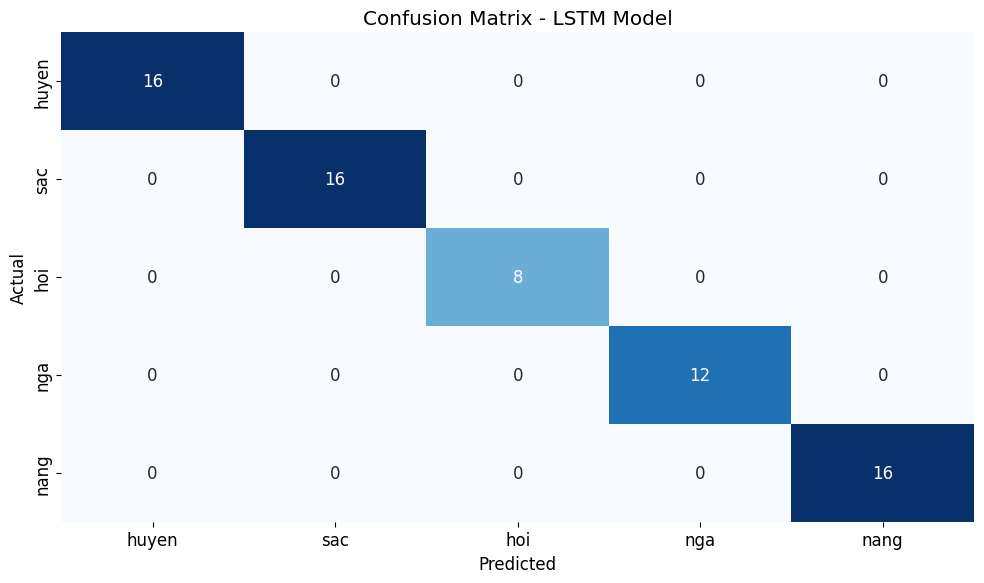

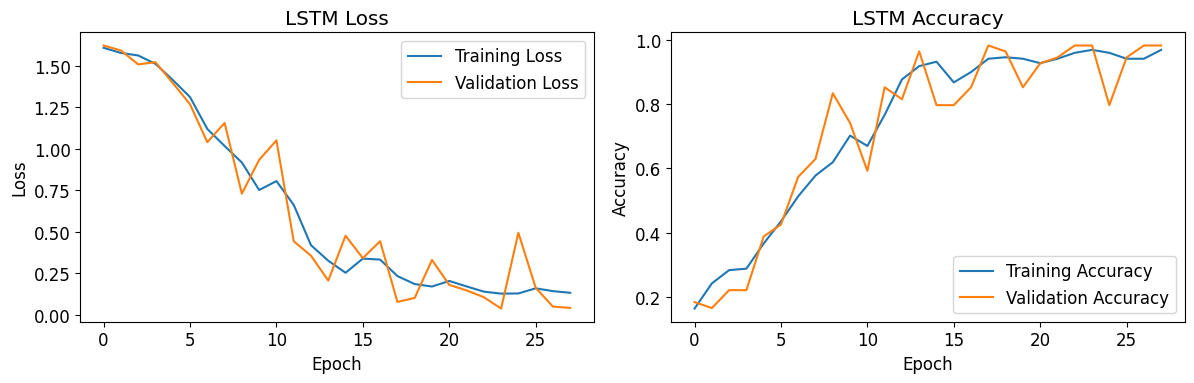

In [12]:
# Callback để lưu mô hình tốt nhất và early stopping
def get_callbacks(model_name):
    return [
        callbacks.ModelCheckpoint(
            f'{MODEL_DIR}/{model_name}_best.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True
        )
    ]

# Huấn luyện và đánh giá mô hình
def train_and_evaluate(model, model_name, X_train, y_train, X_val, y_val, X_test, y_test, class_names, class_weight_dict):
    print(f"\n=== HUẤN LUYỆN MÔ HÌNH {model_name.upper()} ===")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        callbacks=get_callbacks(model_name),
        class_weight=class_weight_dict,
        verbose=1
    )

    # Đánh giá mô hình
    print(f"\n=== ĐÁNH GIÁ MÔ HÌNH {model_name.upper()} ===")
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Dự đoán
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes, target_names=[class_names[cls] for cls in classes]))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[class_names[cls] for cls in classes],
                yticklabels=[class_names[cls] for cls in classes])
    plt.title(f'Confusion Matrix - {model_name.upper()} Model')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Vẽ biểu đồ loss và accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name.upper()} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name.upper()} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return test_accuracy, test_loss

# Huấn luyện và đánh giá từng mô hình
models_dict = {
    'lstm': lstm_model
}
results = {}

for model_name, model in models_dict.items():
    try:
        test_accuracy, test_loss = train_and_evaluate(
            model, model_name, X_train, y_train, X_val, y_val, X_test, y_test, class_names, class_weight_dict
        )
        results[model_name] = {'accuracy': test_accuracy, 'loss': test_loss}
    except Exception as e:
        print(f"❌ Lỗi khi huấn luyện mô hình {model_name}: {str(e)}")
        results[model_name] = {'accuracy': 0, 'loss': float('inf')}

## 6. Lưu mô hình tốt nhất

In [13]:
# Xác định mô hình tốt nhất
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = models_dict[best_model_name]

# Lưu mô hình tốt nhất
best_model_path = os.path.join(MODEL_DIR, f'{best_model_name}_model_final.h5')
best_model.save(best_model_path)

# Lưu label encoder
encoder_path = os.path.join(MODEL_DIR, f'{best_model_name}_label_encoder.pkl')
with open(encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)

print(f"\n✅ Mô hình tốt nhất đã được lưu:")
print(f"  - Mô hình: {best_model_path}")
print(f"  - Label encoder: {encoder_path}")
print(f"  - Loại mô hình: {best_model_name.upper()}")
print(f"  - Accuracy: {results[best_model_name]['accuracy']:.4f}")


✅ Mô hình tốt nhất đã được lưu:
  - Mô hình: trained_models\lstm_model_final.h5
  - Label encoder: trained_models\lstm_label_encoder.pkl
  - Loại mô hình: LSTM
  - Accuracy: 1.0000


## 7. Tóm tắt kết quả

In [14]:
print("=== TÓM TẮT KẾT QUẢ HUẤN LUYỆN ===")
print(f"\n📊 Thống kê dữ liệu:")
for cls in classes:
    print(f"  - {class_names[cls]}: {stats[cls]} mẫu")
print(f"  - Tổng cộng: {stats['total']} mẫu")

print(f"\n🤖 Kết quả mô hình:")
for model_name, result in results.items():
    print(f"  - {model_name.upper()} Accuracy: {result['accuracy']:.4f}")
print(f"  - Mô hình tốt nhất: {best_model_name.upper()}")

print(f"\n💾 Mô hình đã được lưu tại:")
print(f"  - {best_model_path}")
print(f"  - {encoder_path}")

print(f"\n🎯 Bước tiếp theo:")
print(f"  - Chạy predict.py để test mô hình")
print(f"  - Hoặc sử dụng mô hình trong ứng dụng thực tế")

=== TÓM TẮT KẾT QUẢ HUẤN LUYỆN ===

📊 Thống kê dữ liệu:
  - huyen: 80 mẫu
  - sac: 80 mẫu
  - hoi: 80 mẫu
  - nga: 60 mẫu
  - nang: 40 mẫu
  - Tổng cộng: 340 mẫu

🤖 Kết quả mô hình:
  - LSTM Accuracy: 1.0000
  - Mô hình tốt nhất: LSTM

💾 Mô hình đã được lưu tại:
  - trained_models\lstm_model_final.h5
  - trained_models\lstm_label_encoder.pkl

🎯 Bước tiếp theo:
  - Chạy predict.py để test mô hình
  - Hoặc sử dụng mô hình trong ứng dụng thực tế
